In [254]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords

import re
from gensim.models import Word2Vec
from pymorphy3 import MorphAnalyzer

## 1. Загрузка данных из SQLite в pandas

In [111]:
df = pd.read_csv("news.csv", encoding='utf-8', encoding_errors='replace')

In [113]:
df

,guid,title,description,url,published_at,comments_count,created_at_utc,rating
0,7609232e-1b7b-43ef-b4f3-4baa4a4b53cb,Когда природа помогает: инновационные пленки у...,Сегодня антибиотикорезистентность — одна из са...,https://scientificrussia.ru/articles/kogda-pri...,2026-01-21T15:30:00,0,2026-01-21T16:23:14.773441,NaN
1,a47a14b1-db82-45a6-b897-a2884a6e7219,Ученые прогнозируют рост экстремальных наводне...,Географы МГУ в составе масштабной международно...,https://scientificrussia.ru/articles/ucenye-pr...,2026-01-21T13:30:00,0,2026-01-21T16:23:16.300212,NaN
2,67708389-039a-43ab-a51c-5abd52431240,Нановолокна защитят древесину,Красноярские ученые разработали защитное покры...,https://scientificrussia.ru/articles/nanovolok...,2026-01-21T11:30:00,0,2026-01-21T16:23:17.972149,NaN
3,79c45072-0198-4296-8f25-04fc69a82612,Выявить рак по запаху: обученные собаки могут ...,Ученые Пенсильванского ветеринарного университ...,https://scientificrussia.ru/articles/vyavit-ra...,2026-01-20T20:00:00,0,2026-01-21T16:23:19.520552,NaN
4,ae9d1d64-e1f8-42f2-b340-079fc46ca5e0,Всегда ли лёд покрыт тонким слоем воды?,Лёд в вашем морозильнике сильно отличается от ...,https://scientificrussia.ru/articles/vsegda-li...,2026-01-20T19:30:00,0,2026-01-21T16:23:21.082622,NaN
...,...,...,...,...,...,...,...,...
5086,8cae3d3d-d65a-46ae-b3ad-7575506a1259,Объяснение порядка и беспорядка в кристалличес...,Новая теоретическая модель раскрывает структур...,https://scientificrussia.ru/articles/obyasneni...,2020-12-30T13:22:00,0,2026-01-22T06:11:21.354329,NaN
5087,cedb124a-6964-40c7-83e6-2fa05e08e167,Поздравление с Новым годом от президента РАН А...,Президент Российской академии наук Александр С...,https://scientificrussia.ru/articles/pozdravle...,2020-12-30T12:17:00,0,2026-01-22T06:11:22.825489,NaN
5088,22af8740-0c79-46fd-b6f8-b85939efe56d,Святки — волшебные дни января,И.И. Шангина.\r\nФото: Айвар Валеев / АиФ. Свя...,https://scientificrussia.ru/articles/svyatki-v...,2020-12-30T12:09:00,0,2026-01-22T06:11:24.304716,NaN
5089,6060c900-0795-4766-ab6f-9141f4efa1b3,"Как устроена обсерватория ""Спектр-РГ""",Мировое научное сообщество продолжает искать о...,https://scientificrussia.ru/articles/kak-ustro...,2020-12-30T12:03:00,0,2026-01-22T06:11:25.869466,NaN


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5091 entries, 0 to 5090
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   guid            5091 non-null   object 
 1   title           5091 non-null   object 
 2   description     5091 non-null   object 
 3   url             5091 non-null   object 
 4   published_at    5091 non-null   object 
 5   comments_count  5091 non-null   int64  
 6   created_at_utc  5091 non-null   object 
 7   rating          996 non-null    float64
dtypes: float64(1), int64(1), object(6)
memory usage: 318.3+ KB


In [119]:
df.describe()

,comments_count,rating
count,5091.000000,996.000000
mean,2.467099,6.084337
std,18.619767,7.238293
min,0.000000,-11.000000
25%,0.000000,3.000000
50%,0.000000,5.000000
75%,0.000000,8.000000
max,623.000000,81.000000


## 2. Предобработка текста

In [123]:
zero_imputer = SimpleImputer(strategy="constant", fill_value=0)
zero_columns = ["comments_count", "rating"]

df[zero_columns] = zero_imputer.fit_transform(df[zero_columns])

In [125]:
df.isna().sum()

guid              0
title             0
description       0
url               0
published_at      0
comments_count    0
created_at_utc    0
rating            0
dtype: int64

In [137]:
# Инициализируем морфоанализатор и список стоп-слов
morph = MorphAnalyzer()
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

# Регулярка для выделения слов (русские и латинские буквы)
TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)


def preprocess_text(text: str):
    """
    Полная предобработка одного текста:
    - приведение к нижнему регистру,
    - выделение токенов,
    - фильтрация по длине и стоп-словам,
    - лемматизация через pymorphy3.

    Возвращает список лемм (строк).
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in RUSSIAN_STOPWORDS:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in RUSSIAN_STOPWORDS:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas

In [139]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]

Сегодня антибиотикорезистентность — одна из самых острых угроз глобальному здоровью. По оценкам ВОЗ, ...


['сегодня',
 'антибиотикорезистентность',
 'самый',
 'острый',
 'угроза',
 'глобальный',
 'здоровье',
 'оценка',
 'воз',
 'год',
 'супербактерия',
 'superbug',
 'микроб',
 'устойчивый',
 'весь',
 'известный',
 'настоящий',
 'время',
 'антибиотик',
 'уносить',
 'миллион',
 'жизнь',
 'год',
 'поиск',
 'решение',
 'проблема',
 'учёный',
 'частый',
 'обращаться',
 'природа',
 'именно',
 'стык',
 'биология',
 'химия',
 'медицина',
 'технология',
 'рождаться',
 'прорывный',
 'разработка',
 'уникальный',
 'многослойный',
 'антимикробный',
 'плёнка',
 'создать',
 'команда',
 'учёный',
 'кабардино',
 'балкарский',
 'государственный',
 'университет',
 'бербеков',
 'кбга',
 'антибиотик',
 'спасение',
 'инфекция',
 'изменить',
 'ход',
 'медицинский',
 'история',
 'значительно',
 'увеличить',
 'продолжительность',
 'жизнь',
 'однако',
 'отмечать',
 'заведовать',
 'кафедра',
 'микробиология',
 'вирусология',
 'иммунология',
 'медицинский',
 'академия',
 'кбга',
 'заир',
 'хараев',
 'массовый',
 'нер

In [141]:
N_DOCS = 5090

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['сегодня',
 'антибиотикорезистентность',
 'самый',
 'острый',
 'угроза',
 'глобальный',
 'здоровье',
 'оценка',
 'воз',
 'год',
 'супербактерия',
 'superbug',
 'микроб',
 'устойчивый',
 'весь',
 'известный',
 'настоящий',
 'время',
 'антибиотик',
 'уносить',
 'миллион',
 'жизнь',
 'год',
 'поиск',
 'решение',
 'проблема',
 'учёный',
 'частый',
 'обращаться',
 'природа',
 'именно',
 'стык',
 'биология',
 'химия',
 'медицина',
 'технология',
 'рождаться',
 'прорывный',
 'разработка',
 'уникальный']

## 3. Обучение Word2Vec и векторизация документов

In [143]:
w2v_model = Word2Vec(
    sentences=tokenized_texts,  # список документов, каждый документ = список лемм
    vector_size=120,            # размерность эмбеддинга слова
    window=5,                   # ширина контекста
    min_count=5,                # игнорируем слова реже 5 раз
    workers=4,                  # параллельные потоки
    sg=1,                       # 1 = Skip-gram, 0 = CBOW
    epochs=10,                  # сколько раз пройтись по корпусу
)

w2v_model

In [145]:
w2v_model.wv.most_similar("воз", topn=10)

[('спид', 0.6902262568473816),
 ('гепатит', 0.6821078658103943),
 ('дезинформация', 0.6576954126358032),
 ('акушерский', 0.6510507464408875),
 ('туберкулёз', 0.645358681678772),
 ('вакцинация', 0.6356523633003235),
 ('пролечить', 0.6337890028953552),
 ('неотложный', 0.630582332611084),
 ('переливание', 0.623884916305542),
 ('challenges', 0.6235380172729492)]

In [147]:
for test_word in ["вакцинация", "дезинформация", "гепатит", "спид", "туберкулёз"]:
    if test_word not in w2v_model.wv:
        continue

    print(f"\nПохожие слова для «{test_word}»:")
    for word, score in w2v_model.wv.most_similar(test_word, topn=5):
        print(f"  {word:15s} {score:.3f}")



Похожие слова для «вакцинация»:
  бцж             0.762
  эпидемический   0.756
  побороть        0.749
  дезинформация   0.747
  приобретаться   0.741

Похожие слова для «дезинформация»:
  спид            0.817
  участиться      0.784
  побороть        0.781
  недаром         0.775
  сдерживание     0.775

Похожие слова для «гепатит»:
  герпес          0.866
  туберкулёз      0.851
  грибковый       0.848
  ревматоидный    0.841
  артрит          0.839

Похожие слова для «спид»:
  дезинформация   0.817
  акушерский      0.803
  грозный         0.787
  пресечение      0.779
  подчёркиваться  0.773

Похожие слова для «туберкулёз»:
  гепатит         0.851
  грибковый       0.837
  вич             0.823
  риновирусный    0.807
  малярия         0.796


In [149]:
def document_vector(tokens, model: Word2Vec):
    """
    Строит вектор документа как среднее по векторам слов.
    Слова, которых нет в модели, игнорируются.
    Если нет ни одного слова, выдаём нулевой вектор.
    """
    vectors = [model.wv[token] for token in tokens if token in model.wv]

    if not vectors:
        return np.zeros(model.vector_size, dtype="float32")

    return np.mean(vectors, axis=0)



doc_vectors = np.vstack([document_vector(tokens, w2v_model) for tokens in tokenized_texts])
doc_vectors.shape

(5090, 120)

In [151]:
doc_vectors[:3]

array([[-0.09826601,  0.15449348, -0.0622907 , -0.0668766 , -0.14845009,
         0.08141155,  0.20251365,  0.23701553, -0.02574568, -0.05154376,
         0.06619161,  0.05848962,  0.07460232,  0.01968268, -0.05001479,
        -0.0739754 , -0.0586717 ,  0.211367  , -0.11236909, -0.27349946,
        -0.11209784, -0.20523156,  0.3020902 , -0.27928445,  0.04222102,
        -0.11348817, -0.02700595,  0.05702684, -0.03757253, -0.05881285,
        -0.18275334, -0.10390595,  0.11152622,  0.08761059, -0.15822783,
        -0.04397256,  0.06379614, -0.39547583, -0.246587  ,  0.09519079,
        -0.01291077, -0.16565686, -0.0231406 , -0.03581353,  0.04920847,
         0.04046107, -0.18051307, -0.08252084, -0.14964657,  0.24078009,
        -0.10515825,  0.27038753, -0.25000918,  0.04993869,  0.07101408,
         0.11020005,  0.0817853 , -0.00221832,  0.00130216, -0.19991487,
         0.17431903,  0.17463264, -0.3565268 , -0.05416605, -0.01995669,
        -0.26271084,  0.42623115,  0.5200436 , -0.0

## 4. Снижение размерности через PCA

In [158]:
pca = PCA(n_components=2, random_state=42)

doc_vec2d = pca.fit_transform(doc_vectors)
doc_vec2d[:5]

array([[-0.34919065,  0.23699385],
       [-0.40193006,  0.04225641],
       [-0.38312328,  0.33599198],
       [-0.29679903,  0.2971604 ],
       [-0.44082734,  0.4415024 ]], dtype=float32)

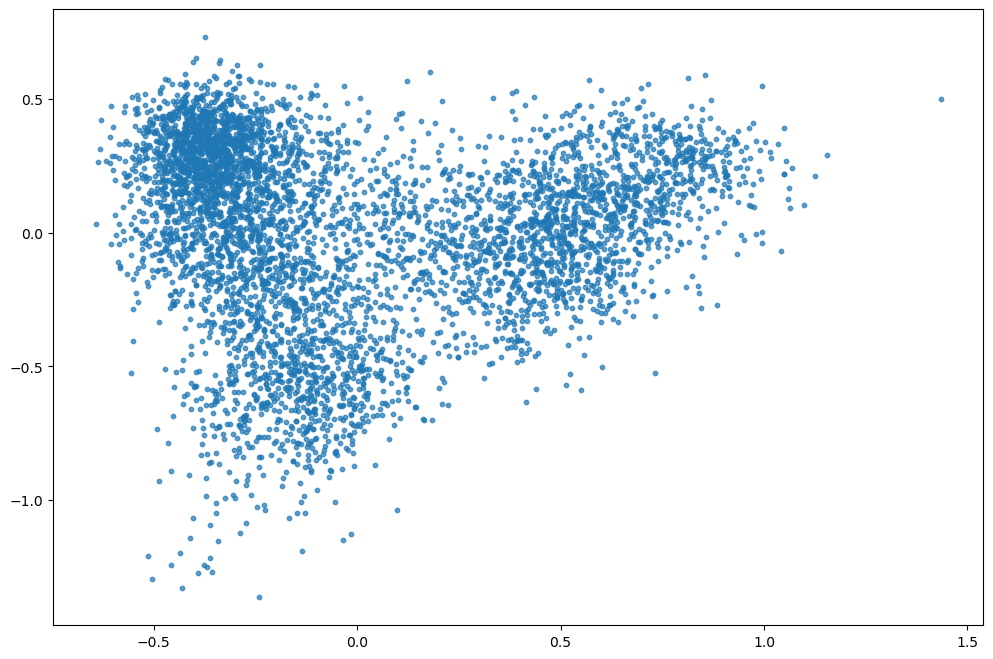

In [163]:
pca = PCA(n_components=2, random_state=42)

doc_vec2d = pca.fit_transform(doc_vectors)

plt.figure(figsize=(12, 8))
plt.scatter(
    doc_vec2d[:, 0], 
    doc_vec2d[:, 1], 
    alpha=0.7, 
    s=10
)
plt.show()

## 5. Кластеризация документов с помощью DBSCAN

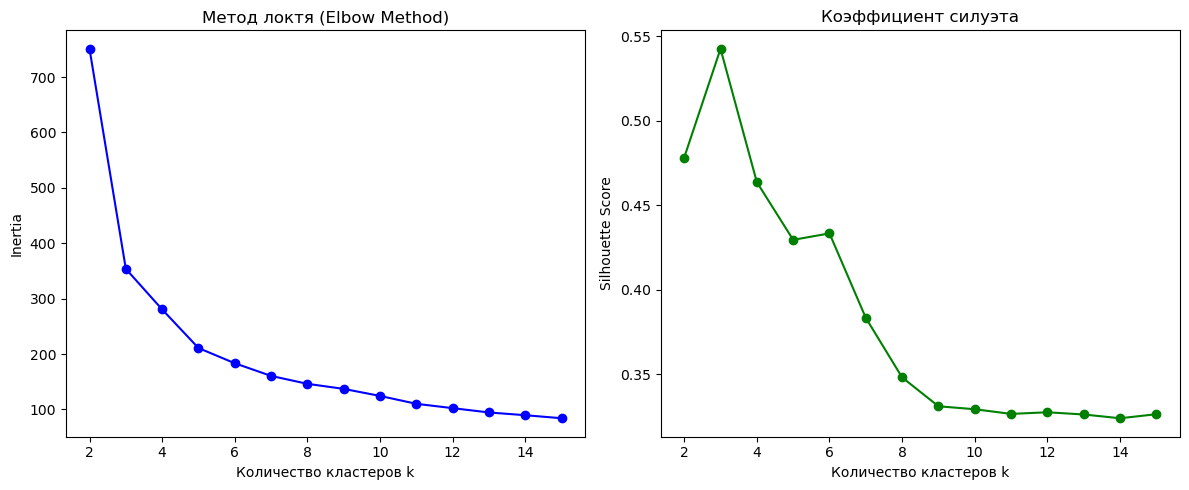

In [182]:
inertias = []
silhouettes = []

K = range(2, 16)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(doc_vec2d)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(doc_vec2d, kmeans.labels_))


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertias, 'bo-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia')
plt.title('Метод локтя (Elbow Method)')

plt.subplot(1,2,2)
plt.plot(K, silhouettes, 'go-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта')
plt.tight_layout()
plt.show()

In [210]:
df = df.drop(df.index[-1])

In [212]:
kmeans_best = KMeans(n_clusters=3, random_state=42)
kmeans_best.fit(doc_vec2d)

clusters_kmeans = kmeans_best.labels_

df["cluster"] = clusters_kmeans

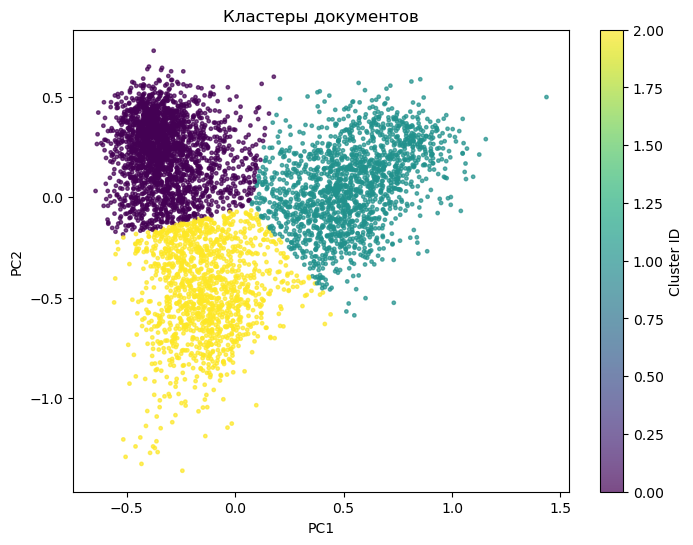

In [221]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    doc_vec2d[:, 0], 
    doc_vec2d[:, 1], 
    c=df["cluster"],
    s=6,
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.title("Кластеры документов")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [226]:
for cluster_num in sorted(df['cluster'].unique()):
    print(f"\n=== КЛАСТЕР {cluster_num} ===")
    titles = df[df['cluster'] == cluster_num]['title'].head(20).tolist()
    for i, title in enumerate(titles, 1):
        print(f"{i}. {title}")



=== КЛАСТЕР 0 ===
1. Когда природа помогает: инновационные пленки ученых КБГУ для защиты слизистых
2. Ученые прогнозируют рост экстремальных наводнений в Европе
3. Нановолокна защитят древесину
4. Выявить рак по запаху: обученные собаки могут обнаружить гемангиосаркому
5. Всегда ли лёд покрыт тонким слоем воды?
6. Воспитатели точнее родителей оценивают способность ребенка к самоконтролю, выяснили психологи МГУ
7. Ученые ВШЭ разработали DeepGQ — Google Maps для G-квадруплексов
8. Первую в мире технологию биокамуфляжа вирусных векторов для генной терапии создали в Сеченовском Университете
9. Новый метод позволяет прогнозировать приступы астмы
10. Как клетки в носу защищают нас от простуды?
11. Загрязнение почв на детских площадках Москвы оценили в МГУ
12. Сорбент из золы очистит воду от токсичных металлов
13. Томские ученые смогли настроить свойства антибактериального геля
14. Электрическое поле управляет «внутренним миром» жидких кристаллов
15. «Умный» стабилизатор напряжения создали у

## 6. Обучение двух моделей

In [249]:
y = df["cluster"]

X_train, X_test, y_train, y_test = train_test_split(doc_vec2d, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape

((4072, 2), (1018, 2))

In [256]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [258]:
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [262]:
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_params, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)
knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [264]:
dt_best = dt_grid.best_estimator_
knn_best = knn_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
y_pred_knn = knn_best.predict(X_test_scaled)

In [270]:
print("\n" + "="*60)
print("CLASSIFICATION REPORT - DECISION TREE")
print("="*60)
print(classification_report(y_test, y_pred_dt))

print("\n" + "="*60)
print("CLASSIFICATION REPORT - KNN")
print("="*60)
print(classification_report(y_test, y_pred_knn))


CLASSIFICATION REPORT - DECISION TREE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441
           1       0.99      1.00      0.99       326
           2       0.99      0.99      0.99       251

    accuracy                           0.99      1018
   macro avg       0.99      0.99      0.99      1018
weighted avg       0.99      0.99      0.99      1018


CLASSIFICATION REPORT - KNN
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       441
           1       0.99      1.00      1.00       326
           2       0.99      1.00      0.99       251

    accuracy                           1.00      1018
   macro avg       0.99      1.00      0.99      1018
weighted avg       1.00      1.00      1.00      1018

